###📦 Step 1: Install Dependencies

In [1]:
!pip install lightgbm seaborn matplotlib scikit-learn pandas numpy -q


### 📚 Step 2: Import Libraries



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

### 🎲 Step 3: Generate Synthetic Dataset


In [3]:
np.random.seed(42)
num_records = 10000

buyer_expected_price = np.random.randint(3000, 10000, num_records)
vendor_price = buyer_expected_price + np.random.randint(-2000, 2000, num_records) # Vendors can be cheaper or more expensive
delivery_days = np.random.randint(3, 30, num_records)
compliance_score = np.random.randint(60, 100, num_records)

# Compute ΔPrice (VendorPrice - BuyerExpectedPrice)
# Negative values mean vendor is cheaper (good)
# Positive values mean vendor is more expensive (bad)
price_diff = vendor_price - buyer_expected_price

# Normalization setup
# Calculate the absolute maximum price difference for scaling
max_abs_price_diff = np.max(np.abs(price_diff))
max_delivery = np.max(delivery_days)

# --- REVISED PRICE SCORE CALCULATION ---
# This new logic properly rewards lower vendor prices (negative price_diff)
# and penalizes higher vendor prices (positive price_diff).
# The score will range from 0 to 100.
#   - If price_diff is maximally negative (vendor much cheaper), score approaches 100.
#   - If price_diff is 0 (vendor matches expected price), score is high (e.g., around 90).
#   - If price_diff is maximally positive (vendor much more expensive), score approaches 0.

# A linear mapping:
# Start with a base good score (e.g., 90 for perfect match).
# Subtract (price_diff / max_abs_price_diff * 90) to scale the penalty/reward.
# If price_diff is negative (cheaper): (negative / positive * 90) is negative.
#   Subtracting a negative value increases the score (e.g., 90 - (-X) = 90 + X).
# If price_diff is positive (expensive): (positive / positive * 90) is positive.
#   Subtracting a positive value decreases the score (e.g., 90 - X).
price_score = 90 - (price_diff / max_abs_price_diff * 90)
price_score = np.clip(price_score, 0, 100) # Ensure scores are within 0-100

# Delivery score (higher = better, so longer delivery = lower score)
delivery_score = np.clip(100 - (delivery_days / max_delivery * 100), 0, 100)

# Final weighted score
final_score = 0.5 * price_score + 0.3 * delivery_score + 0.2 * compliance_score

### 📊 Step 4: Create Dataset


In [4]:
dataset = pd.DataFrame({
    "BuyerExpectedPrice": buyer_expected_price,
    "VendorPrice": vendor_price,
    "PriceDiff": price_diff,
    "DeliveryDays": delivery_days,
    "ComplianceScore": compliance_score,
    "PriceScore": price_score, # Include the intermediate score for inspection
    "DeliveryScore": delivery_score, # Include the intermediate score
    "FinalScore": final_score
})

print("✅ Dataset Created — Sample:")
display(dataset.head(10))


✅ Dataset Created — Sample:


,BuyerExpectedPrice,VendorPrice,PriceDiff,DeliveryDays,ComplianceScore,PriceScore,DeliveryScore,FinalScore
0,3860,4623,763,21,98,55.665,27.586207,55.708362
1,8390,8422,32,3,84,88.560,89.655172,87.976552
2,8226,7733,-493,29,97,100.000,0.000000,69.400000
3,8191,6640,-1551,7,96,100.000,75.862069,91.958621
4,6772,7342,570,12,89,64.350,58.620690,67.561207
5,6092,5986,-106,12,93,94.770,58.620690,83.571207
6,8734,8111,-623,16,77,100.000,44.827586,78.848276
7,9265,10298,1033,4,83,43.515,86.206897,64.219569
8,3466,4171,705,6,86,58.275,79.310345,70.130603
9,8334,6930,-1404,4,86,100.000,86.206897,93.062069


### 📈 Step 5: Visualize Relationships


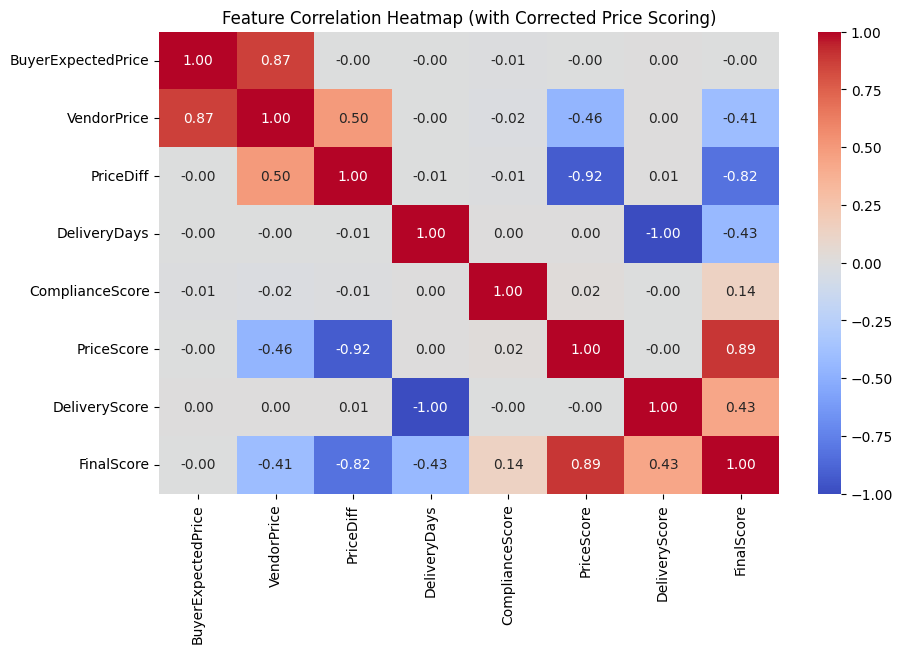

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(dataset.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (with Corrected Price Scoring)")
plt.show()

#### Pairplot to visualize relationships between key features and the target


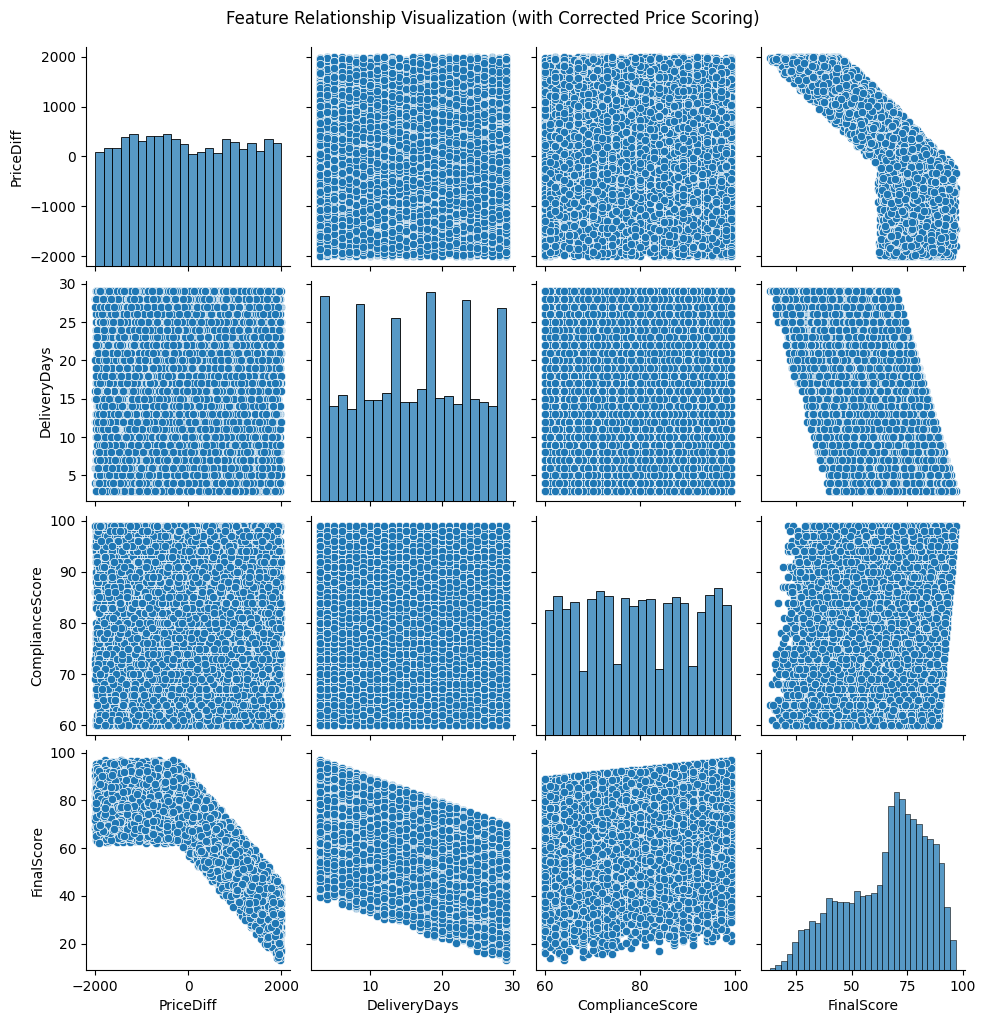

In [6]:
sns.pairplot(dataset[["PriceDiff", "DeliveryDays", "ComplianceScore", "FinalScore"]])
plt.suptitle("Feature Relationship Visualization (with Corrected Price Scoring)", y=1.02)
plt.show()

#### Visualize the effect of PriceDiff on PriceScore directly


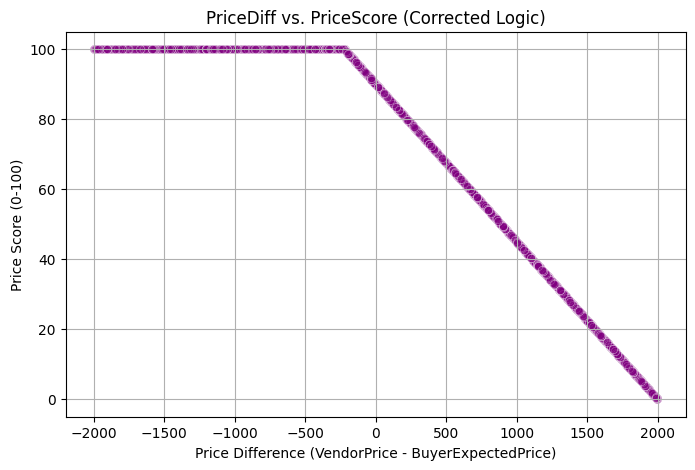

In [7]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=dataset["PriceDiff"], y=dataset["PriceScore"], alpha=0.5, color="purple")
plt.title("PriceDiff vs. PriceScore (Corrected Logic)")
plt.xlabel("Price Difference (VendorPrice - BuyerExpectedPrice)")
plt.ylabel("Price Score (0-100)")
plt.grid(True)
plt.show()

### 🧪 Step 6: Split Train-Test Data


In [8]:
X = dataset[["PriceDiff", "DeliveryDays", "ComplianceScore"]]
y = dataset["FinalScore"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("📘 Training Data Sample (Features):")
display(X_train.head(5))

print("📗 Testing Data Sample (Features):")
display(X_test.head(5))

📘 Training Data Sample (Features):


,PriceDiff,DeliveryDays,ComplianceScore
9254,-527,22,93
1561,1849,29,75
1670,1933,6,81
6087,1611,12,74
6669,596,10,99


📗 Testing Data Sample (Features):


,PriceDiff,DeliveryDays,ComplianceScore
6252,-200,22,70
4684,106,12,91
1731,1196,24,80
4742,507,15,99
4521,-601,18,77


### ⚡ Step 7: Train LightGBM Regressor


In [9]:
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    n_jobs=-1 # Use all available cores
)

print("\n🚀 Training LightGBM Model...")
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='l2', # L2 loss for regression
          callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]) # Early stopping

print("✅ Model Training Complete.")



🚀 Training LightGBM Model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 65.789921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

### 🧮 Step 8: Evaluate Model


In [10]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n🏁 Model Evaluation Results:")
print(f"R² Accuracy: {r2 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.2f}")



🏁 Model Evaluation Results:
R² Accuracy: 99.98%
Mean Absolute Error: 0.18


### 📉 Step 9: Visualization of Performance


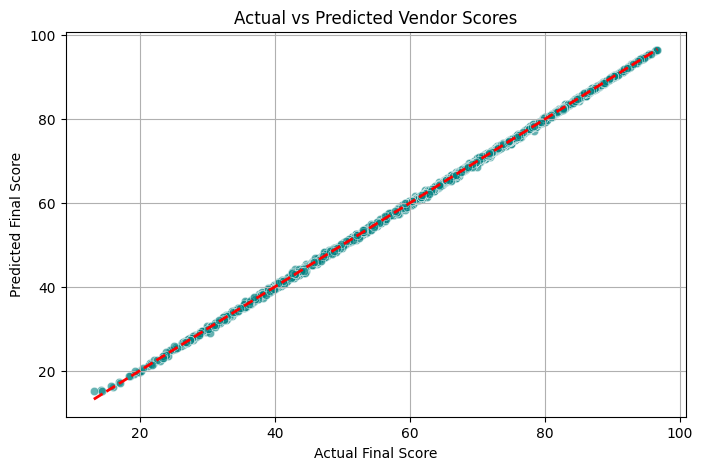

/tmp/ipython-input-3874788438.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


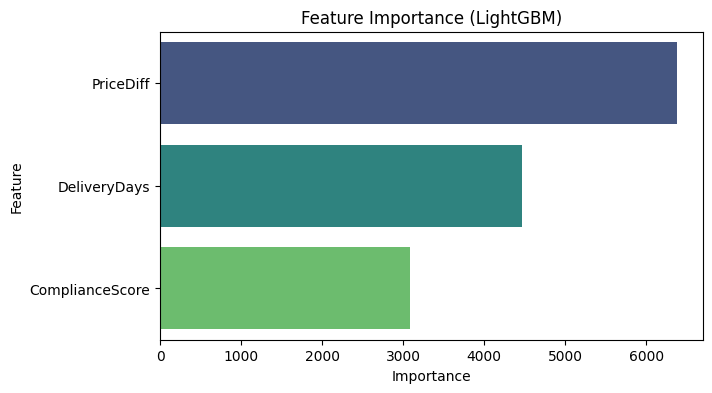

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, color="teal", alpha=0.6)
plt.xlabel("Actual Final Score")
plt.ylabel("Predicted Final Score")
plt.title("Actual vs Predicted Vendor Scores")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.grid(True)
plt.show()

# Feature Importance Plot
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance (LightGBM)")
plt.show()



### 📊 Step 10: Accuracy Summary Bar


/tmp/ipython-input-427875083.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["R² Accuracy", "Mean Abs Error"], y=[r2 * 100, mae], palette="coolwarm")


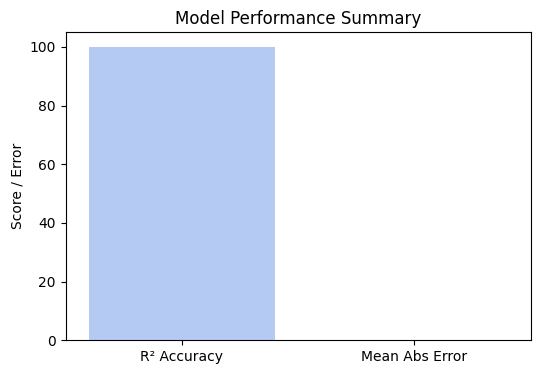

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(x=["R² Accuracy", "Mean Abs Error"], y=[r2 * 100, mae], palette="coolwarm")
plt.title("Model Performance Summary")
plt.ylabel("Score / Error")
plt.show()


### 🔍 Step 11: Example Prediction


In [13]:
print("\n--- Example Vendor Prediction ---")
example_good = pd.DataFrame({
    "PriceDiff": [-1000],          # Vendor is significantly cheaper
    "DeliveryDays": [8],           # Reasonable delivery
    "ComplianceScore": [92]        # Good compliance
})
predicted_score_good = model.predict(example_good)[0]
print("\n🧾 Example Input (Good Vendor):")
display(example_good)
print(f"🎯 Predicted Vendor Final Score: {predicted_score_good:.2f}")

example_bad = pd.DataFrame({
    "PriceDiff": [1500],           # Vendor is significantly more expensive
    "DeliveryDays": [25],          # Long delivery
    "ComplianceScore": [70]        # Average compliance
})
predicted_score_bad = model.predict(example_bad)[0]
print("\n🧾 Example Input (Bad Vendor):")
display(example_bad)
print(f"🎯 Predicted Vendor Final Score: {predicted_score_bad:.2f}")

example_average = pd.DataFrame({
    "PriceDiff": [100],            # Slightly more expensive
    "DeliveryDays": [15],          # Average delivery
    "ComplianceScore": [85]        # Good compliance
})
predicted_score_average = model.predict(example_average)[0]
print("\n🧾 Example Input (Average Vendor):")
display(example_average)
print(f"🎯 Predicted Vendor Final Score: {predicted_score_average:.2f}")



--- Example Vendor Prediction ---

🧾 Example Input (Good Vendor):


,PriceDiff,DeliveryDays,ComplianceScore
0,-1000,8,92


🎯 Predicted Vendor Final Score: 90.14

🧾 Example Input (Bad Vendor):


,PriceDiff,DeliveryDays,ComplianceScore
0,1500,25,70


🎯 Predicted Vendor Final Score: 29.19

🧾 Example Input (Average Vendor):


,PriceDiff,DeliveryDays,ComplianceScore
0,100,15,85


🎯 Predicted Vendor Final Score: 74.41


In [14]:
model.booster_.save_model("vendor_rank_model.txt")
